In [84]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan,acorr_breusch_godfrey
from statsmodels.tsa.arima_model import ARMAResults 

In [392]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
from statsmodels.tsa.seasonal import seasonal_decompose
import csv
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sn
import statistics
import scipy.stats
import numpy.linalg
from scipy.stats import spearmanr,pearsonr, kstest,shapiro, anderson, normaltest
import itertools
import statsmodels.stats.diagnostic


Забираем данные из файла и сортируем по дате. 

In [205]:
master_data=pd.read_csv('Bitcoin_Historical_Price.csv')
master_data.sort_values(by='Date',ascending = False)
master_data.head()
# df = pd.read_csv('Bitcoin_Historical_Price.csv',parse_dates=['Date'])
# df = df.set_index('Date')
# data =df.iloc[1300:,]
# data.asfreq('W').head() 

,Date,Close
0,01-08-2017,2710.67
1,02-08-2017,2804.73
2,03-08-2017,2895.89
3,04-08-2017,3252.91
4,05-08-2017,3213.94


In [330]:
master_data.describe()

,Close
count,215.000000
mean,8512.205395
std,4371.927870
min,2710.670000
25%,4379.645000
50%,7621.300000
75%,11341.300000
max,19497.400000


Построим график временного ряда

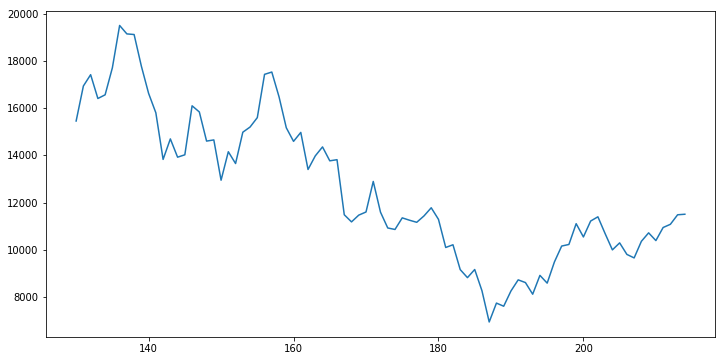

In [423]:
# data_30 = pd.Series(master_data)
master_data.Close[130:].plot(figsize=(12,6))


ACF and PACF 

Критерий Дики-Фуллера: p=0.509855
Критическое значение {'1%': -3.462818103072159, '5%': -2.8758145932936805, '10%': -2.574378674548251}


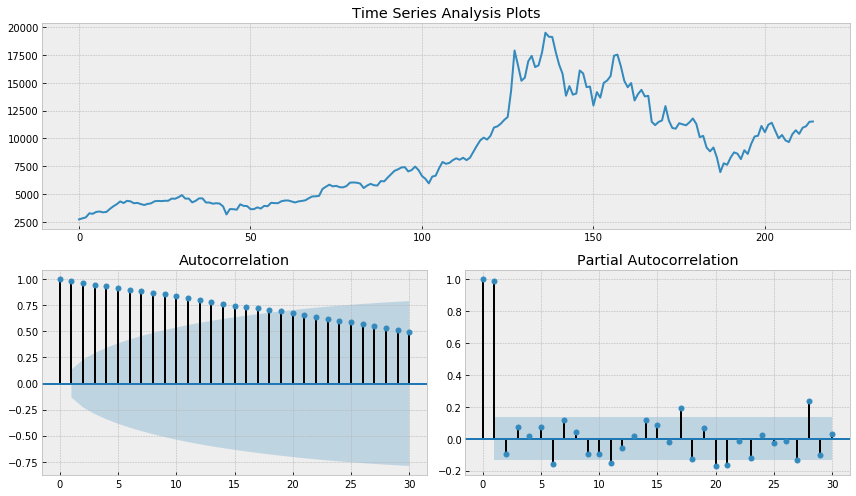

In [309]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax,alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        print("Критическое значение",sm.tsa.stattools.adfuller(y)[4])

        plt.tight_layout()
    return 

tsplot(master_data.Close, lags=30)

Получили стационарный ряд

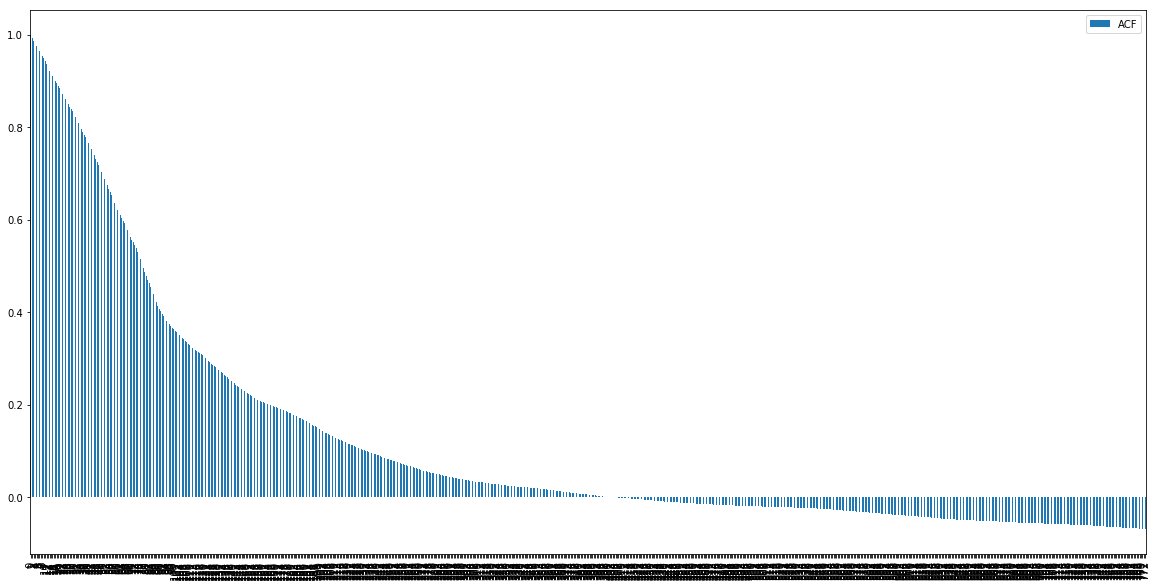

In [158]:
acf_plot = pd.DataFrame(acf(master_data['Close'], nlags=772))
acf_plot.columns=['ACF']
acf_plot.plot(kind='bar',figsize=(20,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029AAA7F7198>]],
      dtype=object)

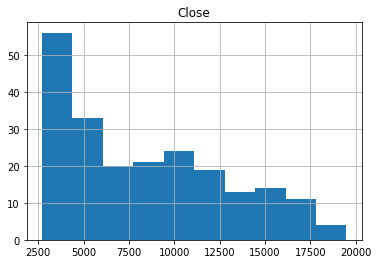

In [319]:
master_data.hist()


In [323]:
otg1diff = (master_data.set_index('Date')).diff(periods=1).dropna()
# print(otg1diff)
test = sm.tsa.adfuller(otg1diff.Close)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.4128892017978494
p-value:  0.01052724913117235
Critical values:  {'1%': -3.462818103072159, '5%': -2.8758145932936805, '10%': -2.574378674548251}
единичных корней нет, ряд стационарен


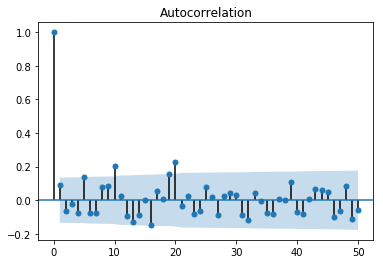

Критерий Дики-Фуллера: p=0.010527
Критическое значение {'1%': -3.462818103072159, '5%': -2.8758145932936805, '10%': -2.574378674548251}


In [346]:
sm.graphics.tsa.plot_acf(otg1diff.Close, lags=50, alpha = 0.05)
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(otg1diff.Close)[1])
print("Критическое значение",sm.tsa.stattools.adfuller(otg1diff.Close)[4])

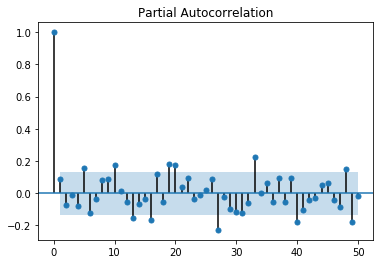

In [347]:
fig = sm.graphics.tsa.plot_pacf(otg1diff.Close, lags=50)
plt.show()

In [196]:
otg2diff = (master_data.set_index('Date')).diff(periods=2).dropna()
# print(otg1diff)
test = sm.tsa.adfuller(otg2diff.Close)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -4.153929749315009
p-value:  0.0007877447457831102
Critical values:  {'1%': -3.438882201132452, '5%': -2.865305765357574, '10%': -2.568775270215655}
единичных корней нет, ряд стационарен


In [351]:
# Define the p, d and q parameters to take any value between 0 and 2
p  = q = range(0, 2)
d = (1,1)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
for param in pdq:
#     mod = sm.tsa.ARIMA(master_data.Close, order=param)
    mod = sm.tsa.ARIMA(master_data.Close, order=param)
    results = mod.fit()
#     print(results.summary())
    print('ARIMA _aic ',ARMAResults.aic(results), param)


ARIMA _aic  3388.9045683250515 (0, 1, 0)
ARIMA _aic  3388.842175261626 (0, 1, 1)
ARIMA _aic  3388.9045683250515 (0, 1, 0)
ARIMA _aic  3388.842175261626 (0, 1, 1)
ARIMA _aic  3389.1288155034636 (1, 1, 0)
ARIMA _aic  3387.6310692319516 (1, 1, 1)
ARIMA _aic  3389.1288155034636 (1, 1, 0)
ARIMA _aic  3387.6310692319516 (1, 1, 1)


ARIMA _aic  3409.7095065894314 (1, 0, 1)

In [352]:
model = sm.tsa.ARIMA(master_data.Close, order=(0,1,0)).fit()
print (model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  214
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1692.452
Method:                           css   S.D. of innovations            658.337
Date:                Fri, 24 May 2019   AIC                           3388.905
Time:                        02:27:03   BIC                           3395.637
Sample:                             1   HQIC                          3391.625
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.1305     45.003      0.914      0.362     -47.074     129.335


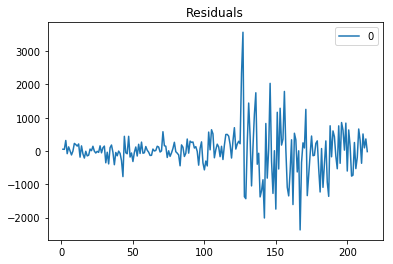

In [353]:
residuals = pd.DataFrame(model.resid)
# fig, ax = plt.plots(1,2)
fig  = residuals.plot(title="Residuals")
# residuals.plot(kind='kde', title='Density', ax=ax[1],figsize=(20, 10))
plt.show()

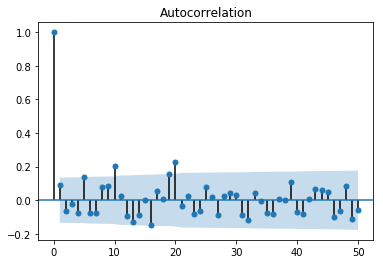

In [359]:
sm.graphics.tsa.plot_acf(model.resid, lags=50, alpha = 0.05)
plt.show()

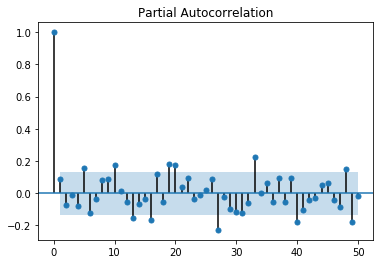

In [360]:
sm.graphics.tsa.plot_pacf(model.resid, lags=50, alpha = 0.05)
plt.show()

In [341]:
print('durbin_watson',durbin_watson(est2.resid))
print('nlag=2',acorr_breusch_godfrey(est2, nlags=2))
print('nlag=3',acorr_breusch_godfrey(est2, nlags=3))
print('nlag=4',acorr_breusch_godfrey(est2, nlags=4))

durbin_watson 1.817738310905051
nlag=2 (2.9674882455697444, 0.22678697850296634, 1.4835155365629786, 0.22919505300483858)
nlag=3 (2.9812883082685673, 0.3945191575087589, 0.9889652908300759, 0.39890891556543684)
nlag=4 (4.275719386067539, 0.36997540373371607, 1.0652383084497634, 0.3747277233104306)


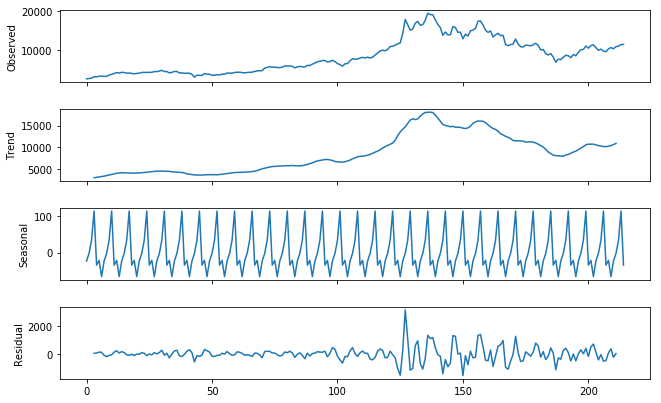

In [311]:
result = sm.tsa.seasonal_decompose(master_data.Close,model='additive',freq = 7)
fig = result.plot()
fig.set_size_inches(10, 6)
plt.show()

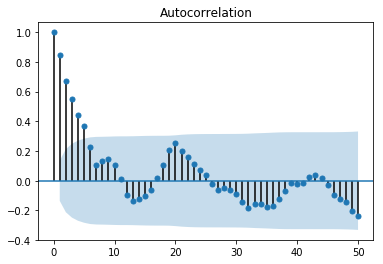

In [363]:
otg7diff = (master_data.set_index('Date')).diff(periods=7).dropna()
sm.graphics.tsa.plot_acf(otg7diff, lags=50, alpha = 0.05)
plt.show()

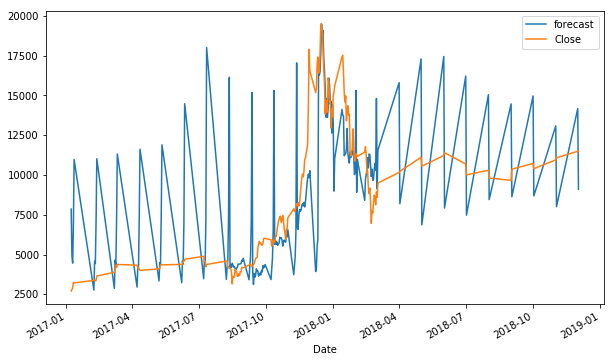

In [279]:
fig = model_fit.plot_predict(dynamic=False)
fig.set_size_inches(10, 6)
plt.show()

In [358]:
# Define the p, d and q parameters to take any value between 0 and 2
d=p=q= range(0, 2)


# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
for param_seasonal in seasonal_pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(master_data.Close,
                                            order=(0,1,0),
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

        results = mod.fit()

        print('SARIMA{}x{}7 - AIC:{}'.format((0,1,0), param_seasonal, results.aic))
    except:
        continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 1, 0) x (0, 1, 1, 7)
SARIMAX: (0, 1, 0) x (1, 0, 0, 7)
SARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:3372.898582291911
SARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:3269.1809695040683
SARIMA(0, 1, 0)x(0, 1, 0, 7)7 - AIC:3425.1791569621073
SARIMA(0, 1, 0)x(0, 1, 1, 7)7 - AIC:3181.5223775804134
SARIMA(0, 1, 0)x(1, 0, 0, 7)7 - AIC:3284.2985380062732
SARIMA(0, 1, 0)x(1, 0, 1, 7)7 - AIC:3270.653023160173
SARIMA(0, 1, 0)x(1, 1, 0, 7)7 - AIC:3276.142087343534
SARIMA(0, 1, 0)x(1, 1, 1, 7)7 - AIC:3182.2375658915853


ARIMA(1, 0, 1)x(1, 0, 1, 7)7 - AIC:3272.57621686961

In [295]:
from scipy.stats import spearmanr,pearsonr, kstest,shapiro, anderson, normaltest
est2=model
result = anderson(model.resid)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
stat, p = normaltest(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
stat, p = shapiro(model.resid)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
kstest(residuals, 'norm')


Statistic: 7.796
15.000: 0.566, data does not look normal (reject H0)
10.000: 0.644, data does not look normal (reject H0)
5.000: 0.773, data does not look normal (reject H0)
2.500: 0.902, data does not look normal (reject H0)
1.000: 1.073, data does not look normal (reject H0)
Statistics=43.559, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.886, p=0.000
Sample does not look Gaussian (reject H0)


KstestResult(statistic=1.0, pvalue=0.0)

In [377]:
mod = sm.tsa.statespace.SARIMAX(master_data.Close,
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 1,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())
t = stats.t(len(master_data))
tcr = t.ppf(1-0.05/2)
print(tcr)
print(abs(results.tvalues) > tcr)


                                 Statespace Model Results                                
Dep. Variable:                             Close   No. Observations:                  215
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 7)   Log Likelihood               -1588.761
Date:                           Fri, 24 May 2019   AIC                           3181.522
Time:                                   03:15:22   BIC                           3188.109
Sample:                                        0   HQIC                          3184.188
                                           - 215                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -1.0001      0.055    -18.183      0.000      -1.108      -0.892
sigma2      4.609e+05   1.19e-07   3.87e+12

In [418]:
mod = sm.tsa.statespace.SARIMAX(master_data.Close,
                                order=(0, 1, 0),
                                seasonal_order=(0, 0, 0,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())
q_test = sm.tsa.stattools.acf(results.resid, qstat=True) 
#свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
tt = pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]})
print((tt))

                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                  215
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1685.449
Date:                Fri, 24 May 2019   AIC                           3372.899
Time:                        04:06:26   BIC                           3376.260
Sample:                             0   HQIC                          3374.257
                                - 215                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.344e+05   2.14e+04     20.304      0.000    3.92e+05    4.76e+05
Ljung-Box (Q):                       75.96   Jarque-Bera (JB):               284.14
Prob(Q):                              0.00   Pr

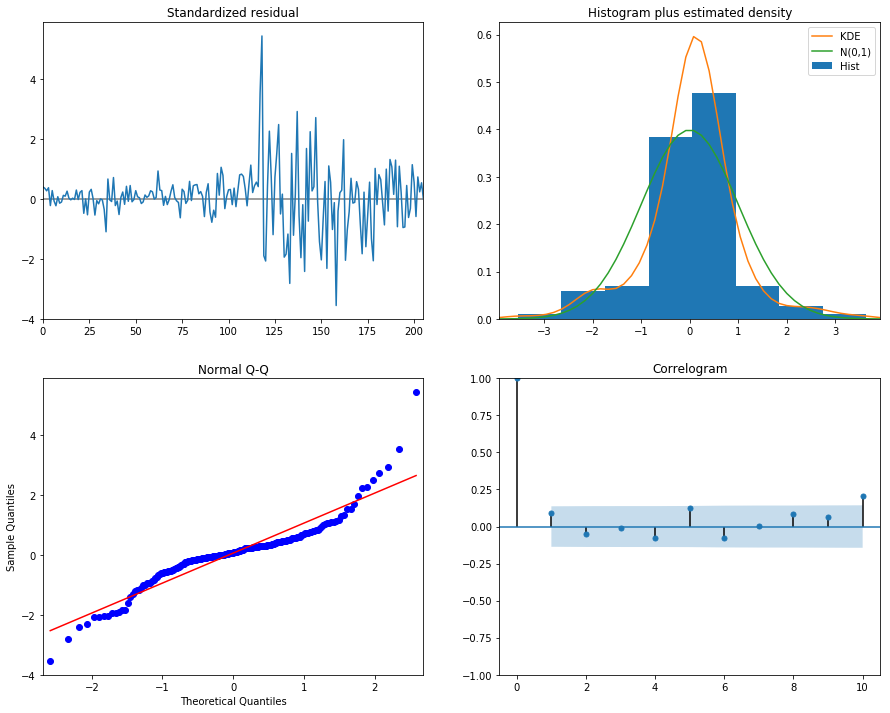

In [414]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [381]:
np.mean(results.resid)

-15.082433317049668

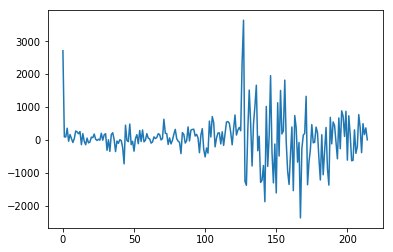

In [415]:
results.resid.plot()

In [386]:
scipy.stats.ttest_ind(results.resid,np.zeros(len(master_data)))

Ttest_indResult(statistic=-0.31186193038172466, pvalue=0.7552973183623612)

In [409]:
q_test = sm.tsa.stattools.acf(results.resid, qstat=True) 
#свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
tt = pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]})
print((tt))
# print (pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    1.722665  0.189350
1    2.620940  0.269693
2    2.626596  0.452846
3    3.832965  0.429083
4    7.236086  0.203666
5    8.098873  0.230949
6   11.595896  0.114656
7   12.833566  0.117706
8   14.567700  0.103516
9   22.661145  0.012069
10  22.918931  0.018146
11  24.306571  0.018473
12  27.763127  0.009764
13  29.549532  0.008799
14  29.550414  0.013650
15  34.562478  0.004560
16  35.182959  0.005886
17  35.201649  0.008915
18  39.367516  0.003958
19  49.836549  0.000234
20  50.211909  0.000341
21  50.431708  0.000513
22  51.861443  0.000522
23  52.486393  0.000676
24  53.959148  0.000673
25  54.059922  0.000998
26  55.307949  0.001049
27  55.322596  0.001554
28  55.862320  0.001962
29  56.200793  0.002589
30  58.284304  0.002138
31  60.889985  0.001538
32  61.087541  0.002090
33  61.087902  0.002949
34  62.240253  0.003084
35  63.287520  0.003303
36  63.350056  0.004473
37  63.350056  0.006073
38  66.101178  0.004318
39  67.547190  0.004169


In [419]:
statsmodels.stats.diagnostic.acorr_ljungbox(results.resid, lags=None, boxpierce=False)

(array([ 1.61438844,  2.39921517,  2.42689243,  3.55617899,  7.36542173,
         8.45962044,  9.72866795, 10.92719265, 12.58377582, 21.08970909,
        21.24871162, 22.74843501, 26.33432405, 27.6549357 , 27.65662602,
        32.60185572, 33.22580398, 33.22920351, 37.85313039, 48.84950963,
        49.07874128, 49.2823239 , 50.60006488, 51.47083877, 52.83403556,
        52.90098013, 54.29955612, 54.42536508, 54.83398593, 55.14605368,
        57.26711432, 60.50818225, 60.77099095, 60.77264962, 61.91464444,
        63.58325242, 63.58652318, 63.58721748, 66.14837574, 67.3607198 ]),
 array([2.03876019e-01, 3.01312428e-01, 4.88648238e-01, 4.69387777e-01,
        1.94850719e-01, 2.06325946e-01, 2.04478082e-01, 2.05858792e-01,
        1.82361840e-01, 2.04766305e-02, 3.08840000e-02, 2.99391731e-02,
        1.53261208e-02, 1.58044380e-02, 2.38199871e-02, 8.34114383e-03,
        1.05514194e-02, 1.56554849e-02, 6.19528370e-03, 3.22914673e-04,
        4.89343641e-04, 7.32546783e-04, 7.68105242e-04

In [76]:
pred = results.get_prediction(start=0, dynamic=False)
pred_ci = pred.conf_int()

In [48]:
pred_dynamic = results.get_prediction(start=1, dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

204 204 215
10


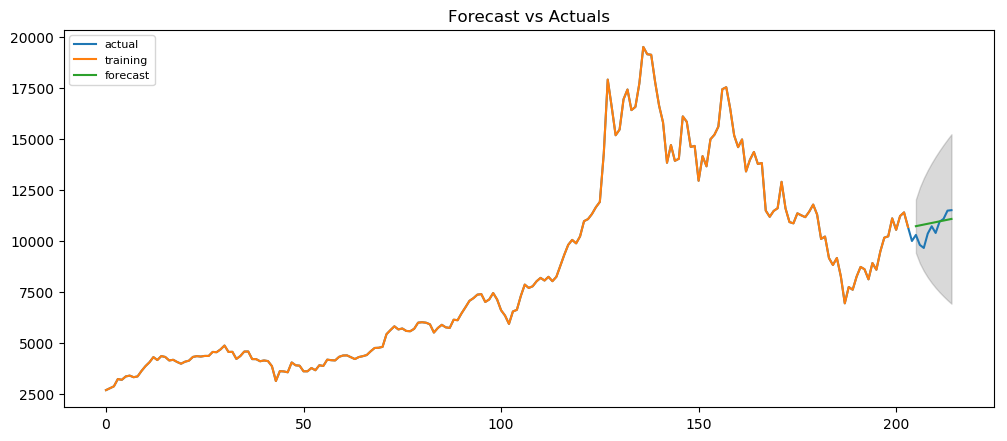

In [420]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
u = int(len(master_data)*0.95)
print(u,int(len(master_data)*0.95), len(master_data))
train = master_data[:u]
test = master_data[u+1:]
print(len(test))
model = ARIMA(train.Close.values, order=(0, 1, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(int(len(master_data)*0.05), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(master_data.Close.values, label='actual')
plt.plot(train.Close.values, label='training')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()